<a href="https://colab.research.google.com/github/yuvalira/Adversarial-Attacks-Article/blob/main/models/Logistic_Regression_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical Model — Logistic Regression**

In this section, we implement **Logistic Regression (LR)** as a baseline model for tabular classification.  

Logistic Regression is a **linear model for classification**:  
- It learns a set of weights for each input feature and combines them in a linear function.  
- This linear combination is passed through the **sigmoid function** (binary case) or **softmax** (multi-class case), producing probabilities for each class.  
- The model predicts the class with the highest probability.  

Key properties:  
- **Interpretability**: the learned weights (coefficients) indicate how each feature influences the prediction.  
- **Simplicity**: provides a fast, well-understood baseline for comparison against more complex models.  
- **Linear decision boundary**: the model separates classes using a hyperplane in the feature space.  
- **Limitations**: struggles when the true relationship between features and target is highly non-linear (where tree-based methods or neural networks may perform better).  

References:  
- [Scikit-learn Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)


## Install & Imports

In [3]:
!pip -q install -U scikit-learn huggingface_hub

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download
from huggingface_hub import notebook_login
notebook_login()


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load Datasets from Hugging Face

In [9]:
repo_id   = "yuvalira/adult_income_balanced"
repo_type = "dataset"  # <-- critical for dataset repos

def read_split_csv(repo_id: str, filename: str, repo_type: str = "dataset") -> pd.DataFrame:
    path = hf_hub_download(
        repo_id=repo_id,
        filename=filename,    # 'train.csv', 'val.csv' at the repo root
        repo_type=repo_type,  # <-- don’t forget this
        # revision="main",    # optional: pin a branch/tag/commit if you want reproducibility
    )
    return pd.read_csv(path)

train_data = read_split_csv(repo_id, "train.csv", repo_type)
val_data   = read_split_csv(repo_id, "val.csv",   repo_type)

print("Train:", train_data.shape, "| Val:", val_data.shape)
display(train_data.head(3))
display(val_data.head(3))

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

Train: (11687, 14) | Val: (2337, 14)


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,36,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,>50K
1,37,Self-emp-not-inc,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,55,United-States,<=50K
2,54,Private,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,1848,40,United-States,>50K


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,51,Private,HS-grad,9,Divorced,Other-service,Other-relative,Black,Male,0,0,32,Haiti,<=50K
1,40,Private,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,30,United-States,<=50K
2,51,Private,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K


## Discover column types & configure target

In [10]:
auto_num = train_data.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
auto_cat = train_data.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Auto numeric:", auto_num)
print("Auto categorical:", auto_cat)

TARGET_COLUMN_NAME = "income"                 # TODO
TARGET_LABELS = [">50K", "<=50K"]             # TODO (order defines 0/1/etc.)
SAMPLE_WEIGHT_COLUMN = None                   # or e.g. "weight"

NUMERIC_FEATURE_NAMES = [c for c in auto_num if c != TARGET_COLUMN_NAME]
CATEGORICAL_FEATURE_NAMES = [c for c in auto_cat if c != TARGET_COLUMN_NAME]

print("\nUsing features:")
print("NUMERIC_FEATURE_NAMES:", NUMERIC_FEATURE_NAMES)
print("CATEGORICAL_FEATURE_NAMES:", CATEGORICAL_FEATURE_NAMES)

Auto numeric: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Auto categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

Using features:
NUMERIC_FEATURE_NAMES: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
CATEGORICAL_FEATURE_NAMES: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


## Prepare dataframes (map target to ints, cast categoricals to str)

In [11]:
train_data = train_data.copy()
val_data   = val_data.copy()

label2id = {lbl: i for i, lbl in enumerate(TARGET_LABELS)}
id2label = {i: lbl for lbl, i in label2id.items()}

def map_target(df: pd.DataFrame):
    if not np.issubdtype(df[TARGET_COLUMN_NAME].dtype, np.integer):
        df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(label2id)
    if df[TARGET_COLUMN_NAME].isna().any():
        bad = df[df[TARGET_COLUMN_NAME].isna()][TARGET_COLUMN_NAME].shape[0]
        raise ValueError(f"{bad} unmapped target values. Check TARGET_LABELS.")
    return df

for df in (train_data, val_data):
    for c in CATEGORICAL_FEATURE_NAMES:
        df[c] = df[c].astype(str)
    map_target(df)

n_classes = len(np.unique(train_data[TARGET_COLUMN_NAME]))
print("Detected #classes:", n_classes, "->", [id2label[i] for i in range(n_classes)])

Detected #classes: 2 -> ['>50K', '<=50K']


## Preprocess & Model pipeline

In [12]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURE_NAMES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURE_NAMES),
    ],
    remainder="drop",
    verbose_feature_names_out=True
)

log_reg = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    multi_class="auto",
    max_iter=2000,
    random_state=RANDOM_STATE
)

clf_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", log_reg),
])

print("Pipeline ready.")

Pipeline ready.


## Train & Evaluate

In [13]:
def split_Xy(df: pd.DataFrame):
    X = df.drop(columns=[TARGET_COLUMN_NAME])
    y = df[TARGET_COLUMN_NAME].values
    sw = df[SAMPLE_WEIGHT_COLUMN].values if SAMPLE_WEIGHT_COLUMN else None
    return X, y, sw

def compute_metrics(y_true, y_pred, y_prob=None, average=None, sample_weight=None):
    acc = accuracy_score(y_true, y_pred, sample_weight=sample_weight)
    if average is None:
        prec = precision_score(y_true, y_pred, sample_weight=sample_weight)
        rec  = recall_score(y_true, y_pred, sample_weight=sample_weight)
        f1   = f1_score(y_true, y_pred, sample_weight=sample_weight)
    else:
        prec = precision_score(y_true, y_pred, average=average, sample_weight=sample_weight, zero_division=0)
        rec  = recall_score(y_true, y_pred, average=average, sample_weight=sample_weight, zero_division=0)
        f1   = f1_score(y_true, y_pred, average=average, sample_weight=sample_weight, zero_division=0)

    out = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    if y_prob is not None:
        try:
            if y_prob.ndim == 1 or (y_prob.shape[1] == 1):
                auc = roc_auc_score(y_true, y_prob, sample_weight=sample_weight)
            elif y_prob.shape[1] == 2:
                auc = roc_auc_score(y_true, y_prob[:, 1], sample_weight=sample_weight)
            else:
                auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro", sample_weight=sample_weight)
            out["roc_auc"] = auc
        except Exception:
            pass
    return out

def run_experiment_lr_train_val(pipeline, train_df, val_df):
    X_train, y_train, sw_train = split_Xy(train_df)
    X_val,   y_val,   sw_val   = split_Xy(val_df)

    t0 = time.time()
    pipeline.fit(X_train, y_train, **({"clf__sample_weight": sw_train} if sw_train is not None else {}))
    train_time = time.time() - t0
    print(f"Training time: {train_time:.2f}s")

    yv_pred = pipeline.predict(X_val)
    yv_prob = pipeline.predict_proba(X_val) if hasattr(pipeline.named_steps["clf"], "predict_proba") else None

    avg = None if n_classes == 2 else "macro"
    val_metrics = compute_metrics(y_val, yv_pred, yv_prob, average=avg, sample_weight=sw_val)
    print("\nValidation metrics:", {k: round(v, 4) for k, v in val_metrics.items()})

    print("\nClassification report (val):")
    print(classification_report(y_val, yv_pred, target_names=[id2label[i] for i in range(n_classes)], zero_division=0))

    print("Confusion matrix (val):")
    print(confusion_matrix(y_val, yv_pred))

    return pipeline, (X_val, y_val, yv_prob)

## Fit & Evaluate

In [14]:
clf_lr, (X_val, y_val, y_prob_val) = run_experiment_lr_train_val(
    clf_lr, train_data, val_data
)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training time: 1.02s

Validation metrics: {'accuracy': 0.8284, 'precision': 0.851, 'recall': 0.7964, 'f1': 0.8228, 'roc_auc': 0.9109}

Classification report (val):
              precision    recall  f1-score   support

        >50K       0.81      0.86      0.83      1168
       <=50K       0.85      0.80      0.82      1169

    accuracy                           0.83      2337
   macro avg       0.83      0.83      0.83      2337
weighted avg       0.83      0.83      0.83      2337

Confusion matrix (val):
[[1005  163]
 [ 238  931]]


## Plot ROC

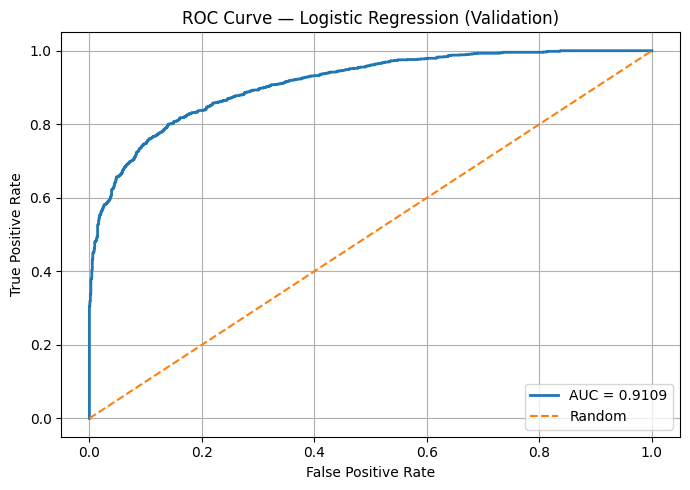

In [15]:
if y_prob_val is not None:
    if n_classes == 2:
        pos_scores = y_prob_val[:, 1] if y_prob_val.ndim > 1 else y_prob_val
        fpr, tpr, _ = roc_curve(y_val, pos_scores)
        auc = roc_auc_score(y_val, pos_scores)
        plt.figure(figsize=(7,5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
        plt.plot([0,1],[0,1],'--', label="Random")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("ROC Curve — Logistic Regression (Validation)")
        plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout(); plt.show()
    else:
        from sklearn.preprocessing import label_binarize
        Y_true_bin = label_binarize(y_val, classes=list(range(n_classes)))
        fpr, tpr, _ = roc_curve(Y_true_bin.ravel(), y_prob_val.ravel())
        auc = roc_auc_score(Y_true_bin, y_prob_val, average="micro", multi_class="ovr")
        plt.figure(figsize=(7,5))
        plt.plot(fpr, tpr, label=f"Micro-avg AUC = {auc:.4f}", linewidth=2)
        plt.plot([0,1],[0,1],'--', label="Random")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Validation, micro-avg) — Logistic Regression")
        plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("No predict_proba available; ROC not plotted.")

## Save the pipeline

In [ ]:
import os
print("Current working directory:", os.getcwd())

In [ ]:
import joblib

# Turn repo_id into a safe filename: remove slashes, spaces, etc.
safe_repo_id = repo_id.replace("/", "_").replace(" ", "_")

# Build model filename
model_path = f"logreg_pipeline_{safe_repo_id}.joblib"

# Save in the same folder as the notebook
joblib.dump(clf_lr, model_path)

print(f"Model saved at: {os.path.abspath(model_path)}")